In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/theano/configdefaults.py:696: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn(
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Global seed set to 0


In [2]:
# /diskmnt/Datasets/Spatial_Transcriptomics/outputs/HT264P1/HT264P1-H2A2/outs

In [3]:
results_folder = '../data/spatial/cell2location/outputs/HT264P1-H2A2'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_sp = sc.read_visium('/diskmnt/Datasets/Spatial_Transcriptomics/outputs/HT264P1/HT264P1-H2A2/outs')
adata_sp.obs['sample'] = list(adata_sp.uns['spatial'].keys())[0]
adata_sp.var_names_make_unique()
adata_sp
# # rename genes to ENSEMBL
# adata_vis.var['SYMBOL'] = adata_vis.var_names
# adata_vis.var_names = adata_vis.var['gene_ids']
# adata_vis.var_names.name = None

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4447 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata_sp.var

gene_ids    feature_types  genome
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38
FAM138A      ENSG00000237613  Gene Expression  GRCh38
OR4F5        ENSG00000186092  Gene Expression  GRCh38
AL627309.1   ENSG00000238009  Gene Expression  GRCh38
AL627309.3   ENSG00000239945  Gene Expression  GRCh38
...                      ...              ...     ...
AC141272.1   ENSG00000277836  Gene Expression  GRCh38
AC023491.2   ENSG00000278633  Gene Expression  GRCh38
AC007325.1   ENSG00000276017  Gene Expression  GRCh38
AC007325.4   ENSG00000278817  Gene Expression  GRCh38
AC007325.2   ENSG00000277196  Gene Expression  GRCh38

[36601 rows x 3 columns]

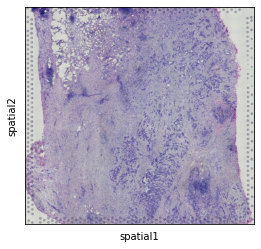

In [6]:
sc.pl.spatial(adata_sp)

In [7]:
# find mitochondria-encoded (MT) genes
adata_sp.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_sp.var.index.to_list()]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_sp.obsm['MT'] = adata_sp[:, adata_sp.var['MT_gene'].values].X.toarray()
adata_sp = adata_sp[:, ~adata_sp.var['MT_gene'].values]

In [8]:
adata_sc = sc.read_h5ad('../data/single_cell/checkpoints/non_eus_processed.h5ad')
adata_sc = adata_sc[[True if 'Exclude' not in ct else False
                    for ct in adata_sc.obs['cell_type_specific_final']]]
adata_sc

View of AnnData object with n_obs × n_vars = 104486 × 29227
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type', 'pollock_cell_type', 'dataset', 'Bailey | ADEX | score', 'Bailey | Squamous-like | score', 'Bailey | Pancreatic-Progenitor | score', 'Bailey | Immunogenic | score', 'Collison | Exocrine-like | score', 'Collison | Quasi-Mesenchymal | score', 'Collison | Classical | score', 'Moffit | Basal | score', 'Moffit | Classical | score', 'subTME | deserted | score', 'subTME | reactive | score', 'raghaven | scBasal | score', 'raghaven | scClassical | score', 'raghaven | IC | score', 'raghaven | Pericyte-like | score', 'raghaven | Fibroblast-like | score', 'raghaven | Inflammatory | score', 'raghaven | TAM-FCN1 | score', 'raghaven | TAM-C1QC | score', 'raghaven | TAM-SPP1 | score', 'elyada | myCAF | score', 'elyada | iCAF

In [9]:
set(adata_sc.obs['cell_type_specific_final'])

{'ADM',
 'Acinar',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'CD8 T cell - Exhausted',
 'DC',
 'Endocrine',
 'Endothelial',
 'Immune - Proliferating',
 'Malignant - Basal',
 'Malignant - Classical',
 'Malignant - IC',
 'Malignant - Proliferating Basal',
 'Malignant - Proliferating Classical',
 'Malignant - Proliferating IC',
 'Mast',
 'NK',
 'Plasma',
 'Stellate',
 'TAM - C1QC',
 'TAM - FCN1',
 'TAM - Proliferating',
 'TAM - SPP1',
 'Treg',
 'iCAF',
 'myCAF'}

In [10]:
adata_ref = adata_sc.copy()
adata_ref.X = adata_ref.layers['counts']

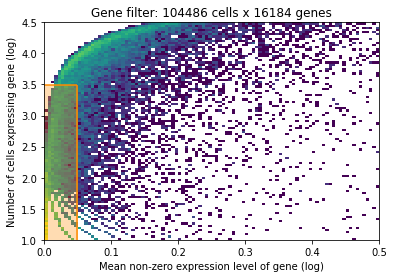

In [11]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [12]:
# downsample to speed up model
# subsample to 5k cells per cell type
cell_types = sorted(set(adata_ref.obs['cell_type_specific_final']))
pool = []
for ct in cell_types:
    f = adata_ref[adata_ref.obs['cell_type_specific_final']==ct]
    ids = list(np.random.choice(f.obs.index.to_list(), size=min(5000, f.shape[0]), replace=False))
    pool += ids
adata_ref = adata_ref[pool]
adata_ref = adata_ref[:, np.sum(adata_ref.X, axis=0)>10]
adata_ref

View of AnnData object with n_obs × n_vars = 70532 × 15956
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type', 'pollock_cell_type', 'dataset', 'Bailey | ADEX | score', 'Bailey | Squamous-like | score', 'Bailey | Pancreatic-Progenitor | score', 'Bailey | Immunogenic | score', 'Collison | Exocrine-like | score', 'Collison | Quasi-Mesenchymal | score', 'Collison | Classical | score', 'Moffit | Basal | score', 'Moffit | Classical | score', 'subTME | deserted | score', 'subTME | reactive | score', 'raghaven | scBasal | score', 'raghaven | scClassical | score', 'raghaven | IC | score', 'raghaven | Pericyte-like | score', 'raghaven | Fibroblast-like | score', 'raghaven | Inflammatory | score', 'raghaven | TAM-FCN1 | score', 'raghaven | TAM-C1QC | score', 'raghaven | TAM-SPP1 | score', 'elyada | myCAF | score', 'elyada | iCAF 

In [13]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample_id',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type_specific_final',
#                         # multiplicative technical effects (platform, 3' vs 5', donor effect)
#                         categorical_covariate_keys=['Method']
                       )

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/cell2location/models/reference/_reference_model.py:112: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [14]:
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Epoch 250/250: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [6:09:53<00:00, 88.77s/it, v_num=1, elbo_train=4.85e+8]


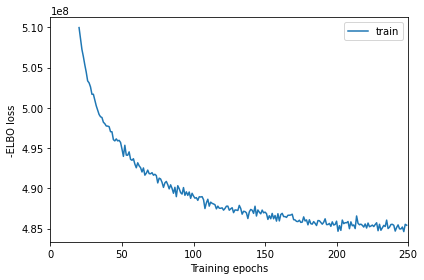

In [15]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=False)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc_ref.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [04:45<00:00,  3.50it/s]


'../data/spatial/cell2location/outputs/HT264P1-H2A2/reference_signatures/sc_ref.h5ad'

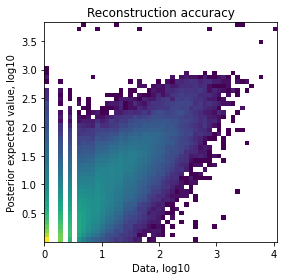

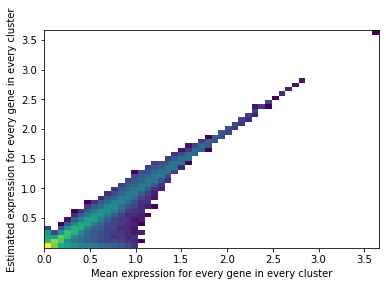

In [17]:
mod.plot_QC()

In [18]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

ADM    Acinar    B cell  CD4 T cell  CD8 T cell
AL627309.1  0.001157  0.002861  0.000379    0.000258    0.000549
LINC00115   0.018091  0.011277  0.009059    0.011319    0.012269
SAMD11      0.005671  0.010034  0.000966    0.000445    0.001176
NOC2L       0.295087  0.220609  0.163232    0.126330    0.128488
PLEKHN1     0.031832  0.052594  0.001448    0.007651    0.009667

In [19]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_sp.var_names, inf_aver.index)
adata_sp = adata_sp[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# # prepare anndata for cell2location model
# scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
# scvi.data.view_anndata_setup(adata_vis)

In [20]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata_sp, batch_key="sample")

In [21]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_sp, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
)

In [22]:
mod.train(max_epochs=10000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 998/10000:  10%|███████████████▎                                                                                                                                         | 998/10000 [1:11:07<10:44:15,  4.29s/it, v_num=1, elbo_train=3.8e+7]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 4826/10000:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 4825/10000 [5:43:27<5:58:23,  4.16s/it, v_num=1, elbo_train=3.48e+7]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 10000/10000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:37:19<00:00,  4.18s/it, v_num=1, elbo_train=3.45e+7]


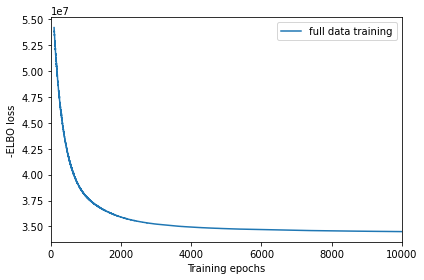

In [23]:
mod.plot_history(100)
plt.legend(labels=['full data training']);

In [24]:
# # In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_sp = mod.export_posterior(
    adata_sp, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_sp.write(adata_file)
adata_file


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████| 999/999 [04:40<00:00,  3.57it/s]


'../data/spatial/cell2location/outputs/HT264P1-H2A2/cell2location_map/sp.h5ad'

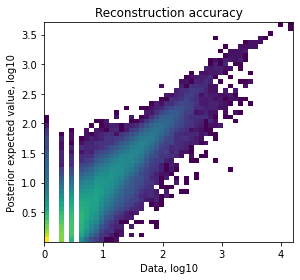

In [25]:
mod.plot_QC()

In [26]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_sp.obs[adata_sp.uns['mod']['factor_names']] = adata_sp.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_sp, list(adata_sp.uns['spatial'].keys())[0])


In [27]:
adata_sp.obs

in_tissue  array_row  array_col        sample  _indices  \
AAACAAGTATCTCCCA-1          1         50        102  HT264P1-H2A2         0   
AAACAATCTACTAGCA-1          1          3         43  HT264P1-H2A2         1   
AAACACCAATAACTGC-1          1         59         19  HT264P1-H2A2         2   
AAACAGAGCGACTCCT-1          1         14         94  HT264P1-H2A2         3   
AAACAGCTTTCAGAAG-1          1         43          9  HT264P1-H2A2         4   
...                       ...        ...        ...           ...       ...   
TTGTTTCACATCCAGG-1          1         58         42  HT264P1-H2A2      4442   
TTGTTTCATTAGTCTA-1          1         60         30  HT264P1-H2A2      4443   
TTGTTTCCATACAACT-1          1         45         27  HT264P1-H2A2      4444   
TTGTTTGTATTACACG-1          1         73         41  HT264P1-H2A2      4445   
TTGTTTGTGTAAATTC-1          1          7         51  HT264P1-H2A2      4446   

                    _scvi_batch  _scvi_labels       ADM    Acinar    B cell  \
AAACAAGTATCTCCCA-1            0             0  1.551713  2.038526  0.128306   
AAACAATCTACTAGCA-1            0             0  0.002300  0.011499  3.446687   
AAACACCAATAACTGC-1            0             0  2.882967  3.016965  0.182160   
AAACAGAGCGACTCCT-1            0             0  0.016863  0.012480  0.150344   
AAACAGCTTTCAGAAG-1            0             0  0.145860  0.014958  0.051911   
...                         ...           ...       ...       ...       ...   
TTGTTTCACATCCAGG-1            0             0  0.490890  0.450785  0.024018   
TTGTTTCATTAGTCTA-1            0             0  4.688289  2.133226  0.037564   
TTGTTTCCATACAACT-1            0             0  1.140519  0.708447  0.022138   
TTGTTTGTATTACACG-1            0             0  0.949502  0.434458  0.017799   
TTGTTTGTGTAAATTC-1            0             0  0.026909  0.011815  0.239132   

                    ...        NK    Plasma  Stellate  TAM - C1QC  TAM - FCN1  \
AAACAAGTATCTCCCA-1  ...  0.211893  0.165891  0.219291    0.129960    0.048493   
AAACAATCTACTAGCA-1  ...  2.634242  5.856985  0.513529    4.486182    2.156103   
AAACACCAATAACTGC-1  ...  0.158094  0.053246  0.037897    0.016986    0.050828   
AAACAGAGCGACTCCT-1  ...  0.247582  0.265176  0.579491    0.328179    0.078539   
AAACAGCTTTCAGAAG-1  ...  0.086113  0.918365  0.210662    1.268419    0.103908   
...                 ...       ...       ...       ...         ...         ...   
TTGTTTCACATCCAGG-1  ...  0.041037  0.062940  0.032358    0.007350    0.012045   
TTGTTTCATTAGTCTA-1  ...  0.108805  0.077747  0.046132    0.063731    0.032993   
TTGTTTCCATACAACT-1  ...  0.057812  0.097099  0.075045    0.021081    0.023446   
TTGTTTGTATTACACG-1  ...  0.035913  0.046455  0.039653    0.011995    0.011094   
TTGTTTGTGTAAATTC-1  ...  0.169675  1.488254  0.088755    2.201824    0.451628   

                    TAM - Proliferating  TAM - SPP1      Treg      iCAF  \
AAACAAGTATCTCCCA-1             1.924711    0.056850  0.295199  0.025400   
AAACAATCTACTAGCA-1             0.999647    0.666631  1.711223  8.413208   
AAACACCAATAACTGC-1             2.227180    0.026338  0.363679  0.022072   
AAACAGAGCGACTCCT-1             0.185152    0.152814  0.247982  0.502526   
AAACAGCTTTCAGAAG-1             0.176889    0.146099  0.132587  0.208185   
...                                 ...         ...       ...       ...   
TTGTTTCACATCCAGG-1             0.403368    0.013907  0.106592  0.025891   
TTGTTTCATTAGTCTA-1             2.572219    0.036546  0.168357  0.015463   
TTGTTTCCATACAACT-1             0.929094    0.016843  0.104566  0.108789   
TTGTTTGTATTACACG-1             0.613001    0.016908  0.088278  0.004787   
TTGTTTGTGTAAATTC-1             0.132254    0.374216  0.086879  1.085451   

                       myCAF  
AAACAAGTATCTCCCA-1  0.772199  
AAACAATCTACTAGCA-1  1.999730  
AAACACCAATAACTGC-1  0.240528  
AAACAGAGCGACTCCT-1  0.459227  
AAACAGCTTTCAGAAG-1  0.513092  
...                      ...  
TTGTTTCACATCCAGG-1  0.319418  


In [28]:
adata_sp.var

gene_ids    feature_types  genome  MT_gene
A1BG    ENSG00000121410  Gene Expression  GRCh38    False
A1CF    ENSG00000148584  Gene Expression  GRCh38    False
A2M     ENSG00000175899  Gene Expression  GRCh38    False
A2ML1   ENSG00000166535  Gene Expression  GRCh38    False
A4GALT  ENSG00000128274  Gene Expression  GRCh38    False
...                 ...              ...     ...      ...
ZXDB    ENSG00000198455  Gene Expression  GRCh38    False
ZXDC    ENSG00000070476  Gene Expression  GRCh38    False
ZYG11B  ENSG00000162378  Gene Expression  GRCh38    False
ZYX     ENSG00000159840  Gene Expression  GRCh38    False
ZZEF1   ENSG00000074755  Gene Expression  GRCh38    False

[14495 rows x 4 columns]

In [29]:
adata_sp.var_names

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS',
       'AADAC', 'AADACL2',
       ...
       'ZSWIM7', 'ZSWIM8', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=14495)

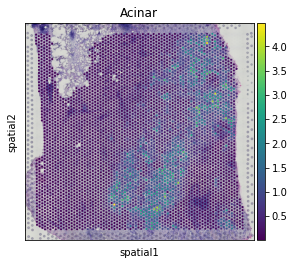

In [30]:
sc.pl.spatial(adata_sp, color=['Acinar'])

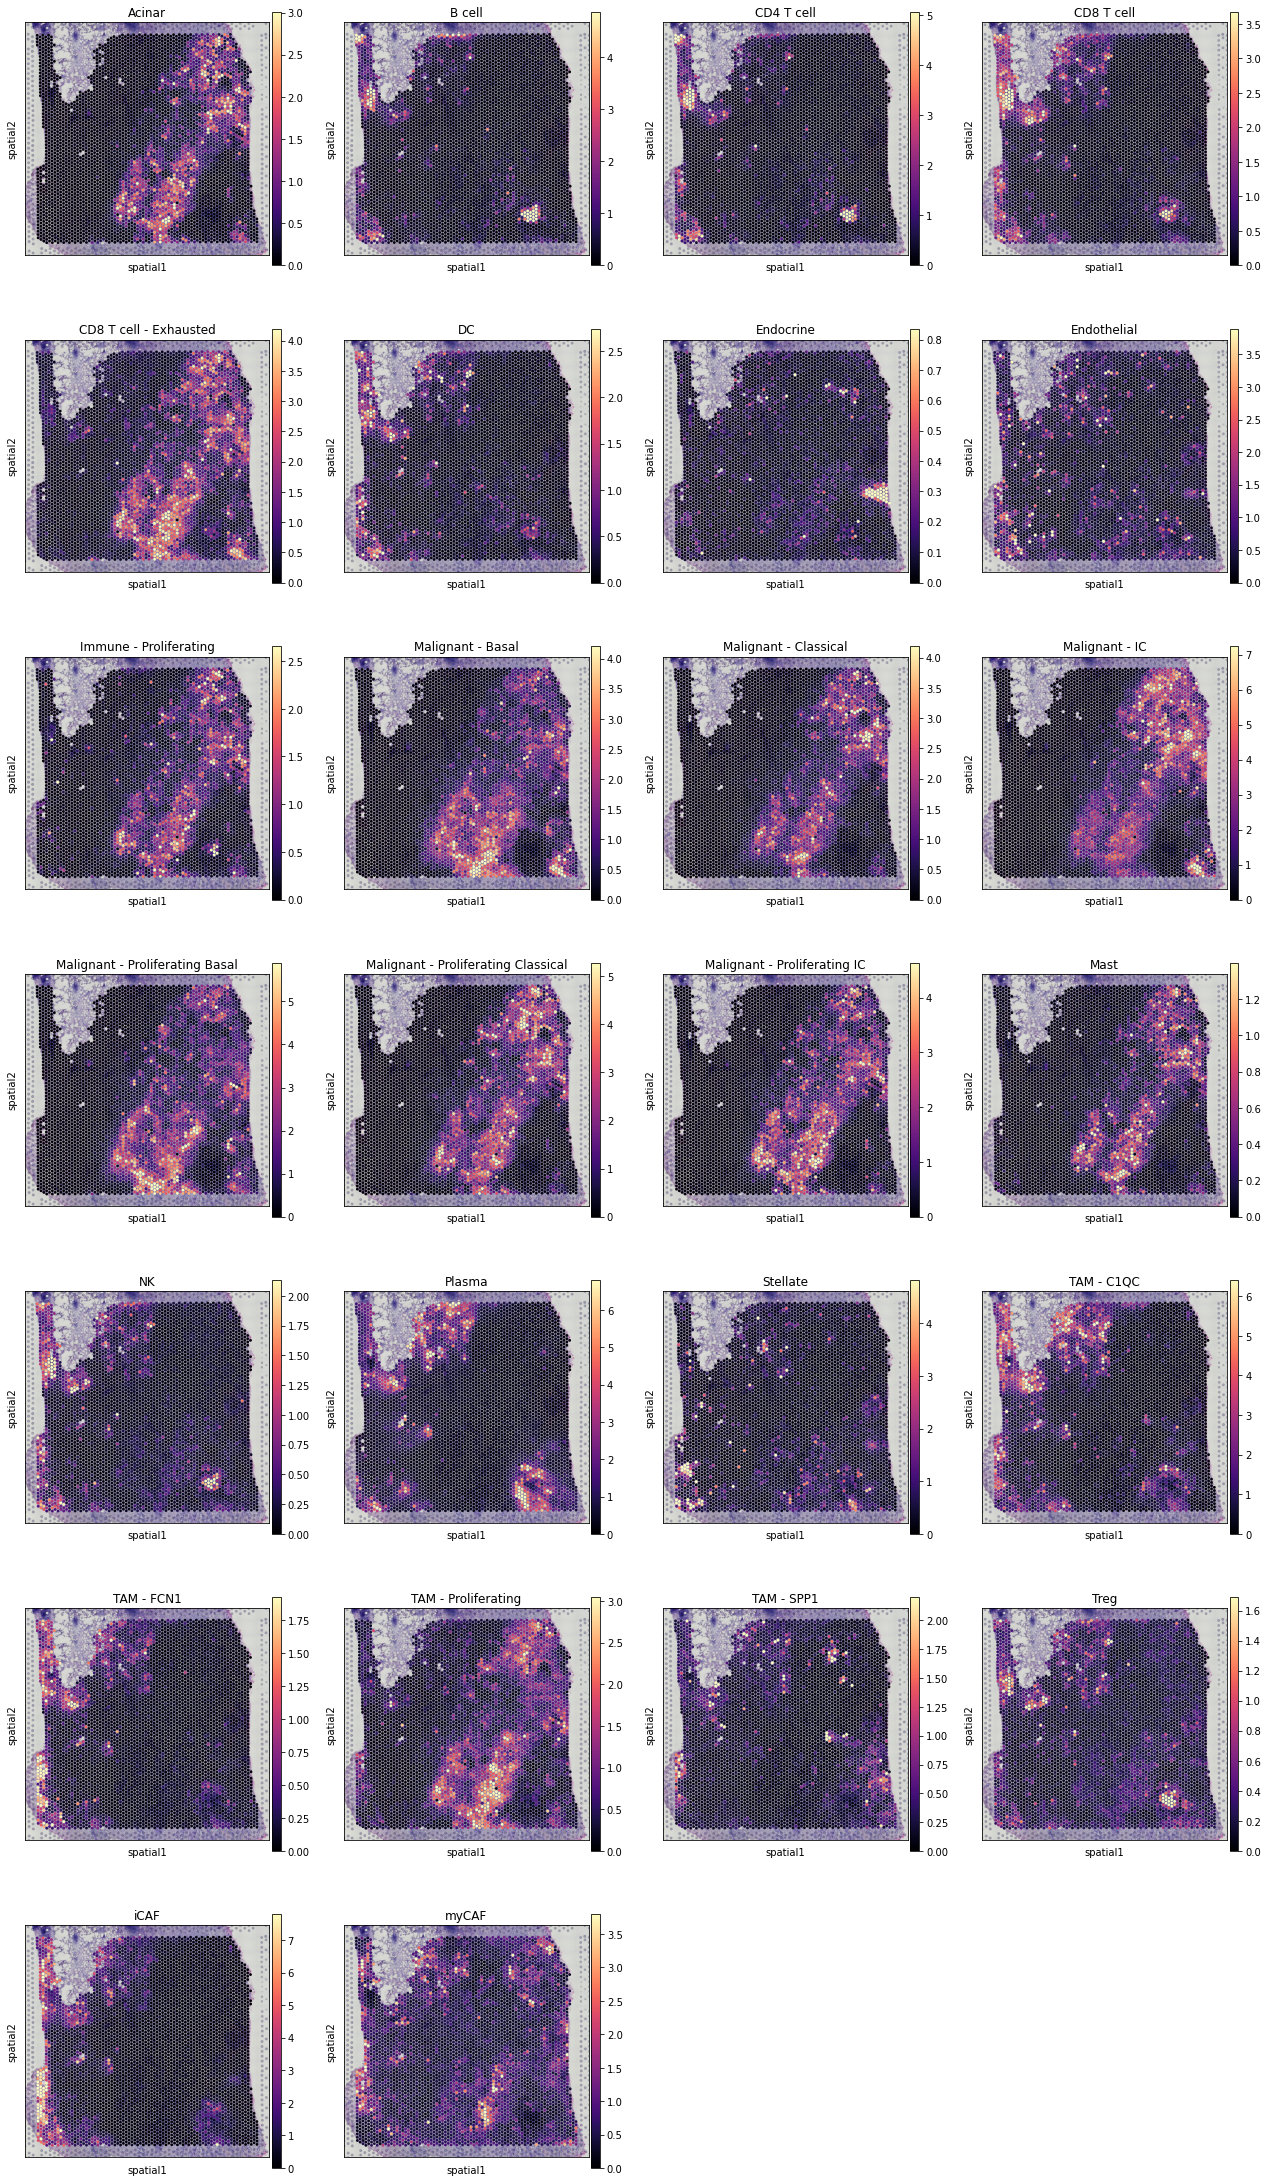

In [31]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=[ct for ct in sorted(set(adata_ref.obs['cell_type_specific_final'])) if ct != 'ADM'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )